In [2]:
!pip install scikit-learn

DEPRECATION: Loading egg at /opt/homebrew/Caskroom/miniconda/base/envs/gfl/lib/python3.11/site-packages/matlabengine-24.2-py3.11.egg is deprecated. pip 24.3 will enforce this behaviour change. A possible replacement is to use pip for package installation. Discussion can be found at https://github.com/pypa/pip/issues/12330


In [3]:
import numpy as np
import scipy.io as sio
from scipy.linalg import toeplitz
from scipy.stats import multivariate_normal
import time
import random
from scipy.linalg import block_diag
from sklearn.metrics import precision_recall_curve, auc
import scipy.stats
import networkx as nx
import seaborn as sns
import matplotlib.pyplot as plt

import sys
# sys.path.append('/Users/yijwang-admin/Documents/Research/GFL/Code/PQN_Python_main')
from minConf.minConf_PQN import minConF_PQN
import random



# Functions

## Functions to generate data

In [4]:
def generate_random_graph(Num_Nodes):
    
    # Create a list of 2D all-one matrices
    blocks = [np.ones((size, size)) for size in Num_Nodes]

    # Generate the block diagonal matrix
    block_diagonal_matrix = block_diag(*blocks)
    
    # Create a graph from adj martrix
    G = nx.from_numpy_array(block_diagonal_matrix)
    
    # Random permutate the edeges in the graph
    G_Random = nx.random_reference(G, niter=1)
    
    # Get adj matrix from a graph
    adj_matrix = nx.to_numpy_array(G_Random)
    
    return adj_matrix, block_diagonal_matrix
    

def add_noise_to_signal(signal, desired_snr_db):
    # Convert signal to numpy array
    signal = np.asarray(signal)
    
    # Calculate signal power
    signal_power = np.mean(signal ** 2)
    
    # Calculate the desired noise power based on the desired SNR (in dB)
    desired_snr_linear = 10 ** (desired_snr_db / 10)
    noise_power = signal_power / desired_snr_linear
    
    # Generate noise with the calculated power
    noise = np.random.normal(0, np.sqrt(noise_power), signal.shape)
    
    # Add noise to the original signal
    noisy_signal = signal + noise
    
    return noisy_signal, noise


def compute_snr(signal, noise):
    # Convert signal and noise to numpy arrays for calculations
    signal = np.asarray(signal)
    noise = np.asarray(noise)

    # Calculate the power of the signal and the noise
    signal_power = np.mean(signal ** 2)
    noise_power = np.mean(noise ** 2)
    
    # Calculate the SNR
    snr = signal_power / noise_power
    
    # Convert SNR to decibels (dB)
    snr_db = 10 * np.log10(snr)
    
    return snr_db


def SynData_iid(n, p, b, snr):
    #n: the number of samples
    #p: the number of features
    #b: the number of groups
    #snr: signal-noise-ratio snr = 10*log_10 E[S^2]/E[N^2] 
    
    # hard coding sparsity setting
    Sparse = [5,5,5,5,5]#[8, 6, 4, 2, 1]
    Group = {}
    for i in range(len(Sparse)):
        Group[i] = int(p/b)*i + np.random.permutation(int(p/b))[0:Sparse[i]]
    #print(Group)

    Mean = np.zeros(p)
    Cov = np.eye(p)
    
    X = np.random.multivariate_normal(Mean, Cov, n)
    #print(X.shape)
    w = np.zeros(p)
    for i in range(len(Group)):
        RandBin = 2*np.random.randint(0, 2, size=len(Group[i]))-1
        w[Group[i]] = RandBin
    w = w[:,np.newaxis]

    Signal = X.dot(w)

    Noisy_Signal, Noise = add_noise_to_signal(Signal, snr)

    SNR_Cmp = compute_snr(Signal, Noise)
    #print("Computed SNR:", SNR_Cmp)

    y = Noisy_Signal
    
    # groups info for L0_GL
    gn = b
    Group = []
    for i in range(1, b + 1):
        Group.append(list(range((i-1)*int(p/b) , i*int(p/b))))

    return y, X, w, Group


def roulette_wheel_selection(population, selection_probabilities):
    """
    Perform roulette wheel selection on a population given precomputed selection probabilities.

    Parameters:
    population (list): The population list where each individual is represented.
    selection_probabilities (list): Precomputed selection probabilities corresponding to the population.

    Returns:
    selected: The selected individual from the population.
    """

    # Ensure the selection probabilities sum to 1
    assert abs(sum(selection_probabilities) - 1.0) < 1e-6, "Probabilities must sum to 1."

    # Generate a random number between 0 and 1
    rand = random.random()

    # Spin the wheel and find the individual corresponding to the random value
    cumulative_probability = 0.0
    for individual, probability in zip(population, selection_probabilities):
        cumulative_probability += probability
        if rand < cumulative_probability:
            return individual


def DisMat(w):
    # w is the true parameter vector with 1 means true feature
    n = len(w)
    c1,c2 = np.where(w)
    #print(c1)
    
    # probability setting for true TFs 
    pop_t = [1, 2, 3, 4, 5]
    prob_t = [0.12, 0.5, 0.3, 0.07, 0.01]
    
    # probability setting for false TFs 
    pop_f = [2, 3, 4, 5, 6]
    prob_f = [0.07, 0.3, 0.4, 0.2, 0.03]
    
    
    S = np.zeros((n,n))
    for i in range(n):
        for j in range(i+1,n):
            if i in c1 and j in c1:
                S[i,j] = roulette_wheel_selection(pop_t, prob_t)
                S[j,i] = S[i,j]
            else:
                S[i,j] = roulette_wheel_selection(pop_f, prob_f)
                S[j,i] = S[i,j]
                
    return S
    

def Data4Matlab(X,w,y):
    d = len(w)
    n = len(y)
    # for matlab
    Folder = "./RandomEnsembleI_Known_k_h/"
    fn1 = Folder + "Xnd.txt"
    fh1 = open(fn1,'w')
    for i in range(n):
        for j in range(d-1):
            fh1.write("%f\t" % (X[i,j]))
        fh1.write("%f\n" % (X[i,d-1]))
    fh1.close()

    fn2 = Folder + "yn.txt"
    fh2 = open(fn2, 'w')
    for i in range(n):
        fh2.write("%f\n"%(y[i]))
    fh2.close()

    fn3 = Folder + "wd.txt"
    fh3 = open(fn3, 'w')
    for i in range(d):
        fh3.write("%f\n"%(w[i]))
    fh3.close()


## Functions of the algorithms

In [16]:
import numpy as np
from scipy.sparse import spdiags
from scipy.linalg import inv
from gurobipy import Model, GRB, QuadExpr




def ProjCSimplexGL_Gurobi(u, k, Group, h):
    n, m = u.shape
    g = len(Group)
    
    # Create matrices H1 and H2
    H1 = np.eye(n)
    f1 = -2*u.flatten()

    H2 = np.zeros((g, g))
    f2 = np.zeros(g)

    H = np.block([[H1, np.zeros((n, g))], [np.zeros((g, n)), H2]])
    f = np.concatenate([f1, f2])
    #print(u.shape)
    #print(f.shape)

    # Constructing constraint matrices A1 and A2
    A1 = np.ones((1, n))
    A2 = np.zeros((1, g))
    gcn = 0

    for i in range(g):
        for j in range(len(Group[i])):
            A1t = np.zeros((1, n))
            A1t[0, Group[i][j]] = 1
            A1 = np.vstack([A1, A1t])
            
            A2t = np.zeros((1, g))
            A2t[0, i] = -1
            A2 = np.vstack([A2, A2t])
            gcn += 1

    A1 = np.vstack([A1, np.zeros((1, n))])
    A2 = np.vstack([A2, np.ones((1, g))])
    A = np.hstack([A1, A2])

    # RHS vector
    b = np.zeros(gcn + 2)
    b[0] = k
    b[-1] = h

    # Lower and upper bounds
    lb = np.zeros(n + g)
    ub = np.ones(n + g)

    # Setup Gurobi model
    model = Model()

    # Add variables
    Q = H
    x = model.addMVar(n + g, ub=1.0, lb=0.0)
    
    model.setObjective(x@Q@x+ x@f)
    model.addConstr(A @ x <= b)
    

    # Set Gurobi parameters
    model.setParam('OutputFlag', 0)
    model.setParam('IterationLimit', 5)

    # Optimize model
    model.optimize()

    # Get the results
    up = x.x[:n]
    zp = x.x[n:]

    #print(up.shape)
    return up[:,np.newaxis]

def ProjCSimplexGL_Gurobi_v2(u, k, Group, h):
    n, m = u.shape
    g = len(Group)
    
    # Create matrices H1 and H2
    H1 = np.eye(n)
    f1 = -2*u.flatten()

    H2 = np.zeros((g, g))
    f2 = np.zeros(g)

    H = np.block([[H1, np.zeros((n, g))], [np.zeros((g, n)), H2]])
    f = np.concatenate([f1, f2])
    #print(u.shape)
    #print(f.shape)

    # Constructing constraint matrices A1 and A2
    A1 = np.ones((1, n))
    A2 = np.zeros((1, g))
    gcn = 0

    for i in range(g):
        for j in range(len(Group[i])):
            A1t = np.zeros((1, n))
            A1t[0, Group[i][j]] = 1
            A1 = np.vstack([A1, A1t])
            
            A2t = np.zeros((1, g))
            A2t[0, i] = -1
            A2 = np.vstack([A2, A2t])
            gcn += 1

    A1 = np.vstack([A1, np.zeros((1, n))])
    A2 = np.vstack([A2, np.ones((1, g))])
    A = np.hstack([A1, A2])

    # RHS vector
    b = np.zeros(gcn + 2)
    b[0] = k
    b[-1] = h

    # Lower and upper bounds
    lb = np.zeros(n + g)
    ub = np.ones(n + g)

    # Setup Gurobi model
    model = Model()

    # Add variables
    Q = H
    x = model.addMVar(n + g, ub=1.0, lb=0.0)
    
    model.setObjective(x@Q@x+ x@f)
    model.addConstr(A @ x <= b)
    

    # Set Gurobi parameters
    model.setParam('OutputFlag', 0)
    model.setParam('IterationLimit', 5)

    # Optimize model
    model.optimize()

    # Get the results
    up = x.x[:n]
    zp = x.x[n:]

    #print(up.shape)
    return up[:,np.newaxis], zp[:,np.newaxis]


def ProjCSimplexGL_Gurobi_LB(u, k, Group, h):
    n, m = u.shape
    g = len(Group)
    
    # Create matrices H1 and H2
    H1 = np.eye(n)
    f1 = -2*u.flatten()

    H2 = np.zeros((g, g))
    f2 = np.zeros(g)

    H = np.block([[H1, np.zeros((n, g))], [np.zeros((g, n)), H2]])
    f = np.concatenate([f1, f2])
    #print(u.shape)
    #print(f.shape)

    # Constructing constraint matrices A1 and A2
    A1 = np.ones((1, n))
    A1t = -np.ones((1, n))
    A1 = np.vstack([A1, A1t])
    A2 = np.zeros((2, g))
    gcn = 0

    for i in range(g):
        for j in range(len(Group[i])):
            A1t = np.zeros((1, n))
            A1t[0, Group[i][j]] = 1
            A1 = np.vstack([A1, A1t])
            
            A2t = np.zeros((1, g))
            A2t[0, i] = -1
            A2 = np.vstack([A2, A2t])
            gcn += 1

    A1 = np.vstack([A1, np.zeros((1, n))])
    A2 = np.vstack([A2, np.ones((1, g))])
    A = np.hstack([A1, A2])

    # RHS vector
    b = np.zeros(gcn + 3)
    b[0] = k
    b[1] = -k+1
    b[-1] = h

    # Lower and upper bounds
    lb = np.zeros(n + g)
    ub = np.ones(n + g)

    # Setup Gurobi model
    model = Model()

    # Add variables
    Q = H
    x = model.addMVar(n + g, ub=1.0, lb=0.0)
    
    model.setObjective(x@Q@x+ x@f)
    model.addConstr(A @ x <= b)
    

    # Set Gurobi parameters
    model.setParam('OutputFlag', 0)
    model.setParam('IterationLimit', 5)

    # Optimize model
    model.optimize()

    # Get the results
    up = x.x[:n]
    zp = x.x[n:]

    #print(up.shape)
    return up[:,np.newaxis]


def ProjCSimplexGL_Gurobi_LB_v2(u, k, Group, h):
    n, m = u.shape
    g = len(Group)
    
    # Create matrices H1 and H2
    H1 = np.eye(n)
    f1 = -2*u.flatten()

    H2 = np.zeros((g, g))
    f2 = np.zeros(g)

    H = np.block([[H1, np.zeros((n, g))], [np.zeros((g, n)), H2]])
    f = np.concatenate([f1, f2])
    #print(u.shape)
    #print(f.shape)

    # Constructing constraint matrices A1 and A2
    A1 = np.ones((1, n))
    A1t = -np.ones((1, n))
    A1 = np.vstack([A1, A1t])
    A2 = np.zeros((2, g))
    gcn = 0

    for i in range(g):
        for j in range(len(Group[i])):
            A1t = np.zeros((1, n))
            A1t[0, Group[i][j]] = 1
            A1 = np.vstack([A1, A1t])
            
            A2t = np.zeros((1, g))
            A2t[0, i] = -1
            A2 = np.vstack([A2, A2t])
            gcn += 1

    A1 = np.vstack([A1, np.zeros((1, n))])
    A2 = np.vstack([A2, np.ones((1, g))])
    A = np.hstack([A1, A2])

    # RHS vector
    b = np.zeros(gcn + 3)
    b[0] = k
    b[1] = -k+1
    b[-1] = h

    # Lower and upper bounds
    lb = np.zeros(n + g)
    ub = np.ones(n + g)

    # Setup Gurobi model
    model = Model()

    # Add variables
    Q = H
    x = model.addMVar(n + g, ub=1.0, lb=0.0)
    
    model.setObjective(x@Q@x+ x@f)
    model.addConstr(A @ x <= b)
    

    # Set Gurobi parameters
    model.setParam('OutputFlag', 0)
    model.setParam('IterationLimit', 5)

    # Optimize model
    model.optimize()

    # Get the results
    up = x.x[:n]
    zp = x.x[n:]

    #print(up.shape)
    return up[:,np.newaxis], zp[:,np.newaxis]

# used for project, comparing to ProjCSimplexGL_Gurobi_v2, it only has one output
def ProjCSimplex_Gurobi_LB(u, k):
    n, m = u.shape
    #g = len(Group)
    
    # Create matrices H1 and H2
    H1 = np.eye(n)
    f1 = -2*u.flatten()

    #H2 = np.zeros((g, g))
    #f2 = np.zeros(g)

    #H = np.block([[H1, np.zeros((n, g))], [np.zeros((g, n)), H2]])
    #f = np.concatenate([f1, f2])
    #print(u.shape)
    #print(f.shape)

    # Constructing constraint matrices A1 and A2
    A1 = np.ones((1, n))
    #A1t = -np.ones((1, n))
    #A1 = np.vstack([A1, A1t])
    
    
    # RHS vector
    b = np.zeros(1)
    b[0] = k
    #b[1] = -k+1

    # Setup Gurobi model
    model = Model()

    # Add variables
    Q = H1
    f = f1
    A = A1
    x = model.addMVar(n, ub=1.0, lb=0.0)
    
    model.setObjective(x@Q@x+ x@f)
    model.addConstr(A @ x == b)
    

    # Set Gurobi parameters
    model.setParam('OutputFlag', 0)
    model.setParam('IterationLimit', 500)

    # Optimize model
    model.optimize()

    #print(x)
    # Get the results
    up = x.x[:n]
    zp = x.x[n:]

    #print(up.shape)
    return up[:,np.newaxis]
    # return x.x

# Experiment

In [6]:
def generate_random_graph(Num_Nodes, NoiseLevel):
    
    # Create a list of 2D all-one matrices
    blocks = [np.ones((size, size)) for size in Num_Nodes]

    # Generate the block diagonal matrix
    block_diagonal_matrix = block_diag(*blocks)
    Num_edge = np.sum(block_diagonal_matrix) - np.sum(Num_Nodes)
    print(Num_edge)
    
    # Create a graph from adj martrix
    G = nx.from_numpy_array(block_diagonal_matrix)
    
    # Random permutate the edeges in the graph
    G_Random = nx.double_edge_swap(G, max_tries=Num_edge, nswap=int(Num_edge*NoiseLevel))
    
    # Get adj matrix from a graph
    adj_matrix = nx.to_numpy_array(G_Random)
    
    return adj_matrix, block_diagonal_matrix

def SynData_iid_GFL_v1(Num_Nodes, Selected_Module, n, snr):
    #Num_Nodes: a list of numbers. Each number is the number of nodes in a graph module
    #Selected_Module: the index of the moduels that are selected as ground truth
    #n: the number of samples to be generated
    #snr: signal-noise-ratio snr = 10*log_10 E[S^2]/E[N^2] 
    
    p = np.sum(Num_Nodes)
    
    Group = {}
    Group[0] = np.arange(0,Num_Nodes[0])
    for i in range(len(Num_Nodes)-1):
        Group[i+1] = np.arange(Group[i][-1]+1, Group[i][-1]+Num_Nodes[i+1]+1)
        
    
    Mean = np.zeros(p)
    Cov = np.eye(p)
    
    X = np.random.multivariate_normal(Mean, Cov, n)
    #print(X.shape)
    w = np.zeros(p)
    for i in range(len(Selected_Module)):
        RandBin = 2*np.random.randint(0, 2)-1
        Sid = Selected_Module[i]
        w[Group[Sid]] = RandBin
    w = w[:,np.newaxis]

    Signal = X.dot(w)

    Noisy_Signal, Noise = add_noise_to_signal(Signal, snr)

    SNR_Cmp = compute_snr(Signal, Noise)
    #print("Computed SNR:", SNR_Cmp)

    y = Noisy_Signal
    

    return y, X, w, Group

def SynData_GFL_v2(Num_Nodes, Selected_Module, n, b, snr):
    #Num_Nodes: a list of numbers. Each number is the number of nodes in a graph module
    #Selected_Module: the index of the moduels that are selected as ground truth
    #n: the number of samples to be generated
    #b: the number of false features that are highly correlated to the ground truth
    #snr: signal-noise-ratio snr = 10*log_10 E[S^2]/E[N^2] 
    
    p = np.sum(Num_Nodes)
    
    Group = {}
    Group[0] = np.arange(0,Num_Nodes[0])
    for i in range(len(Num_Nodes)-1):
        Group[i+1] = np.arange(Group[i][-1]+1, Group[i][-1]+Num_Nodes[i+1]+1)
        
    
    Mean = np.zeros(p)
    
    # Let b features highly correlated to the ground truth feature
    GT_Feature_Ind = list()
    for i in range(len(Selected_Module)):
        Sid = Selected_Module[i]
        GT_Feature_Ind.extend(Group[Sid])
    print(GT_Feature_Ind)
    False_Feature_Ind = list(set(range(p)) - set(GT_Feature_Ind))
    
    print(False_Feature_Ind)
    
    Id1 = random.sample(GT_Feature_Ind, k=b)
    Id2 = random.sample(False_Feature_Ind, k=b)
    
    Cov = np.eye(p)
    for id1t, id2t in zip(Id1, Id2):
        Cov[id1t, id2t] = 0.9
        Cov[id2t, id1t] = 0.9
    
    X = np.random.multivariate_normal(Mean, Cov, n)
    #print(X.shape)
    w = np.zeros(p)
    for i in range(len(Selected_Module)):
        RandBin = 2*np.random.randint(0, 2)-1
        Sid = Selected_Module[i]
        w[Group[Sid]] = RandBin
    w = w[:,np.newaxis]

    Signal = X.dot(w)

    Noisy_Signal, Noise = add_noise_to_signal(Signal, snr)

    SNR_Cmp = compute_snr(Signal, Noise)
    #print("Computed SNR:", SNR_Cmp)

    y = Noisy_Signal
    

    return y, X, w, Group, Cov

## 1.2.1 All feature are iid

In [7]:
Num_Nodes = [8, 5, 6, 9, 7, 10, 6]
AdjMat, BlkMat = generate_random_graph(Num_Nodes, 0.03)

Selected_Module = [1, 4]
n = 100
snr = 10
k = sum(Num_Nodes[Selected_Module[i]] for i in range(len(Selected_Module)))
h = len(Selected_Module)
d = sum(Num_Nodes)

y, X, w, Group = SynData_iid_GFL_v1(Num_Nodes, Selected_Module, n, snr)


340.0


In [8]:
w.shape

(51, 1)

In [9]:
# laplacian matrix L of adj matrix
D = np.diag(np.sum(AdjMat, axis=1))
L = D - AdjMat

In [10]:
max(np.diag(L))

11.0

In [11]:
h = len(Num_Nodes)

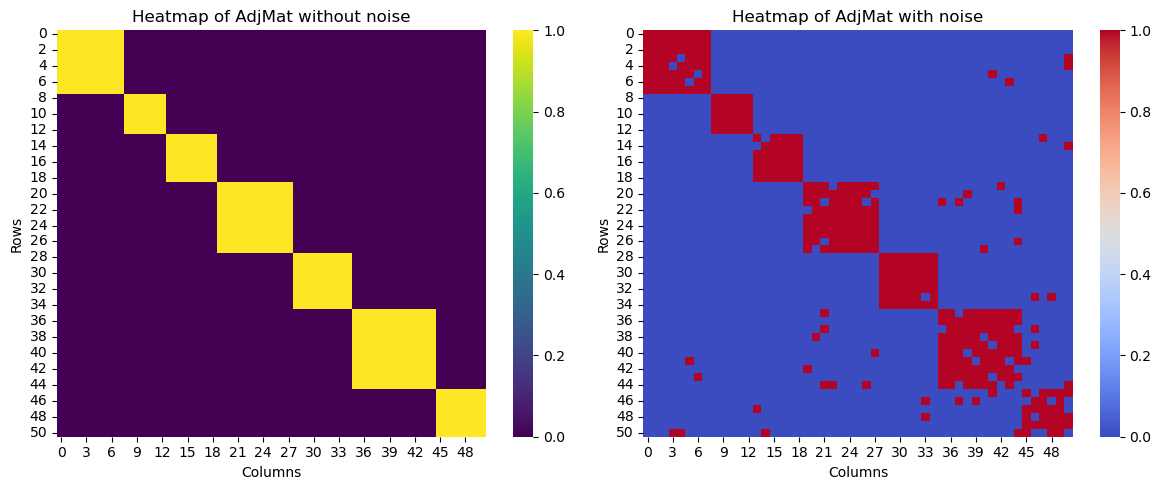

In [12]:
# Create a figure with two subplots
fig, axes = plt.subplots(1, 2, figsize=(12, 5))  # 1 row, 2 columns

# Plot heatmap for the first matrix
sns.heatmap(BlkMat, cmap="viridis", ax=axes[0])
axes[0].set_title("Heatmap of AdjMat without noise")
axes[0].set_xlabel("Columns")
axes[0].set_ylabel("Rows")

# Plot heatmap for the second matrix
sns.heatmap(AdjMat,  cmap="coolwarm", ax=axes[1])
axes[1].set_title("Heatmap of AdjMat with noise")
axes[1].set_xlabel("Columns")
axes[1].set_ylabel("Rows")

# Adjust layout and show the plot
plt.tight_layout()
plt.show()

NameError: name 'uout_ppi' is not defined

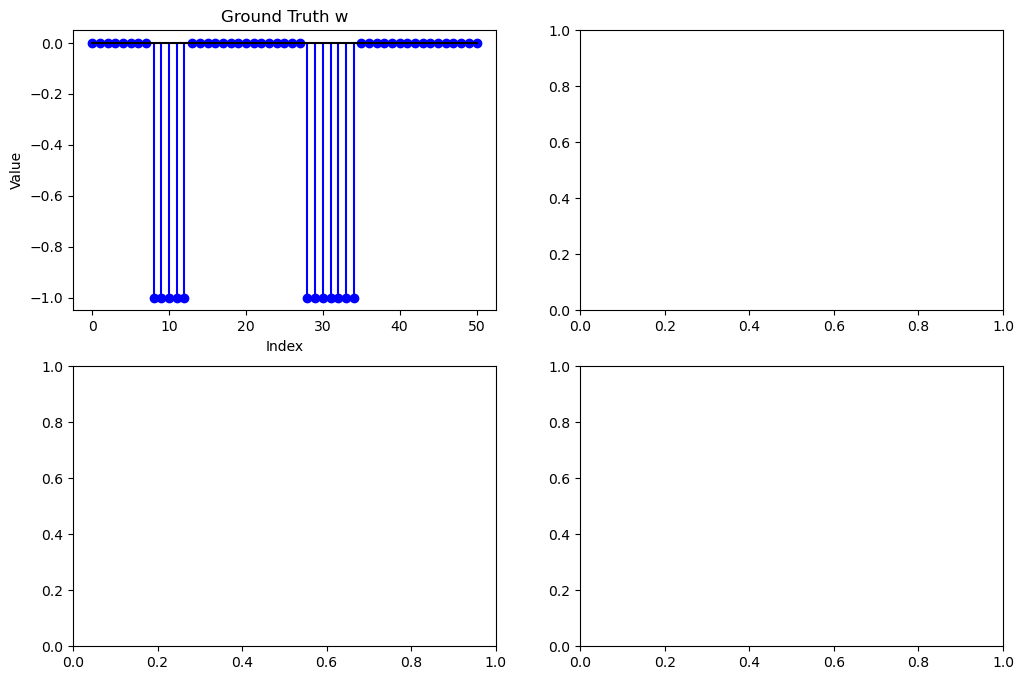

In [13]:
# Create a 2x2 grid of subplots
fig, axes = plt.subplots(2, 2, figsize=(12, 8))  # 2 rows, 2 columns

# Plot the first stem plot (top-left)
axes[0, 0].stem(w, linefmt='b-', markerfmt='bo', basefmt='k')
axes[0, 0].set_title("Ground Truth w")
axes[0, 0].set_xlabel("Index")
axes[0, 0].set_ylabel("Value")

# Plot the second stem plot (top-right)
axes[0, 1].stem(uout_ppi, linefmt='g-', markerfmt='go', basefmt='k')
axes[0, 1].set_title("Boolean GFL Estimate")
axes[0, 1].set_xlabel("Index")
axes[0, 1].set_ylabel("Value")

# Plot the third stem plot (bottom-left)
axes[1, 0].stem(uout, linefmt='r-', markerfmt='ro', basefmt='k')
axes[1, 0].set_title("Neurips 21 Estimate")
axes[1, 0].set_xlabel("Index")
axes[1, 0].set_ylabel("Value")

# Plot the fourth stem plot (bottom-right)
axes[1, 1].stem(feature_prob, linefmt='m-', markerfmt='mo', basefmt='k')
axes[1, 1].set_title("Novel GFL Estimate")
axes[1, 1].set_xlabel("Index")
axes[1, 1].set_ylabel("Value")

# Adjust layout to prevent overlap
plt.tight_layout()

# Show the plots
plt.show()

In [15]:
# method GFL
p = np.sum(Num_Nodes)
uSimplex = np.ones((p, 1)) * (1 / p)
k = 12
pho = 10
lamb = 0.1
# Compute the degree matrix
degree_matrix = np.diag(np.sum(AdjMat, axis=1))
# Compute the Laplacian matrix
L = degree_matrix - AdjMat

options = {'maxIter': 500, 'verbose': 0}

funObj_PPI = lambda w: L0GL_PPI_Obj(w, X, y, L, pho, lamb)
funProj_PPI = lambda w: ProjCSimplex_Gurobi_LB(w, k)
        
uout_ppi, obj, _ = minConF_PQN(funObj_PPI, uSimplex, funProj_PPI, options)
uout_ppi = ProjCSimplex_Gurobi_LB(uout_ppi, k)

Set parameter Username
Set parameter LicenseID to value 2585252
Set parameter LogToConsole to value 0


NameError: name 'L0GL_PPI_Obj' is not defined

In [14]:
X.shape


(100, 1)

In [15]:
y.shape

(100, 1)

In [35]:
import scipy.io as sio
import numpy as np

# Save Python data to MATLAB .mat file
sio.savemat('gfl_data.mat', {
    'X': X,
    'y': y,
    'AdjMat': AdjMat,
    'pho': pho,
    'lamb': lamb
})


In [18]:
# method without graph info
funObj_PPI = lambda w: L0GLObj(w, X, y, pho)
funProj_PPI = lambda w: ProjCSimplex_Gurobi_LB(w, k)
        
uout_, obj, _ = minConF_PQN(funObj_PPI, uSimplex, funProj_PPI, options)
uout = ProjCSimplex_Gurobi_LB(uout_, k)

NameError: name 'L0GLObj' is not defined

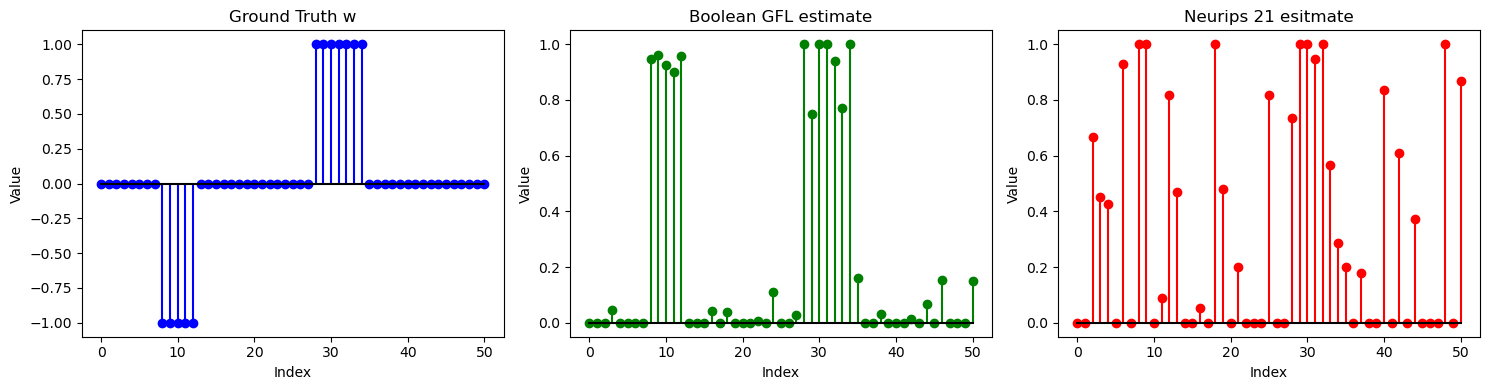

In [41]:
# Create a figure with three subplots in a row
fig, axes = plt.subplots(1, 3, figsize=(15, 4))  # 1 row, 3 columns

# Plot the first stem plot
axes[0].stem(w, linefmt='b-', markerfmt='bo', basefmt='k')
axes[0].set_title("Ground Truth w")
axes[0].set_xlabel("Index")
axes[0].set_ylabel("Value")

# Plot the second stem plot
axes[1].stem(uout_ppi, linefmt='g-', markerfmt='go', basefmt='k')
axes[1].set_title("Boolean GFL estimate")
axes[1].set_xlabel("Index")
axes[1].set_ylabel("Value")

# Plot the third stem plot
axes[2].stem(uout, linefmt='r-', markerfmt='ro', basefmt='k')
axes[2].set_title("Neurips 21 esitmate")
axes[2].set_xlabel("Index")
axes[2].set_ylabel("Value")

# Adjust layout to prevent overlap
plt.tight_layout()

# Show the plots
plt.show()

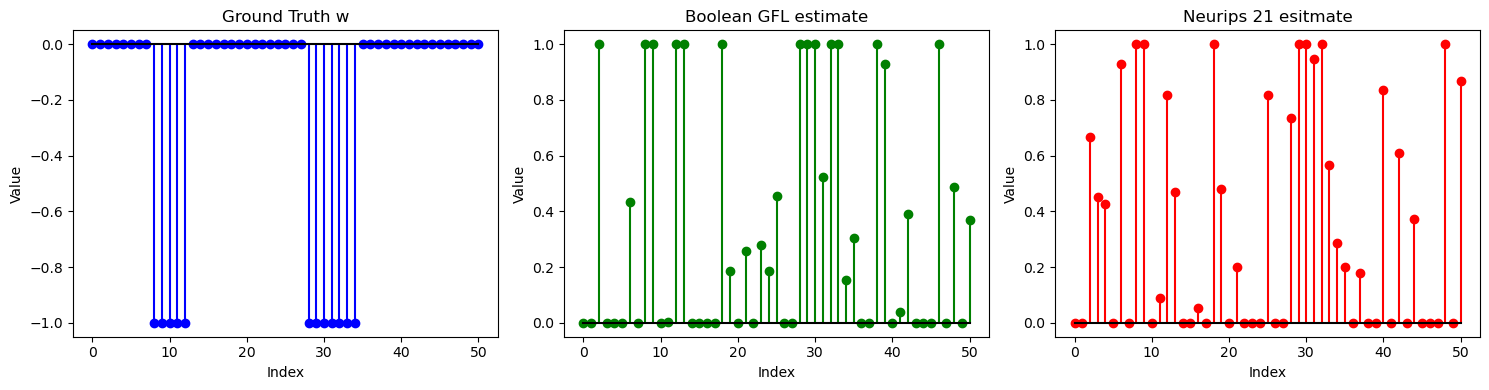

In [28]:
# Create a figure with three subplots in a row
fig, axes = plt.subplots(1, 3, figsize=(15, 4))  # 1 row, 3 columns

# Plot the first stem plot
axes[0].stem(w, linefmt='b-', markerfmt='bo', basefmt='k')
axes[0].set_title("Ground Truth w")
axes[0].set_xlabel("Index")
axes[0].set_ylabel("Value")

# Plot the second stem plot
axes[1].stem(uout_ppi, linefmt='g-', markerfmt='go', basefmt='k')
axes[1].set_title("Boolean GFL estimate")
axes[1].set_xlabel("Index")
axes[1].set_ylabel("Value")

# Plot the third stem plot
axes[2].stem(uout, linefmt='r-', markerfmt='ro', basefmt='k')
axes[2].set_title("Neurips 21 esitmate")
axes[2].set_xlabel("Index")
axes[2].set_ylabel("Value")

# Adjust layout to prevent overlap
plt.tight_layout()

# Show the plots
plt.show()

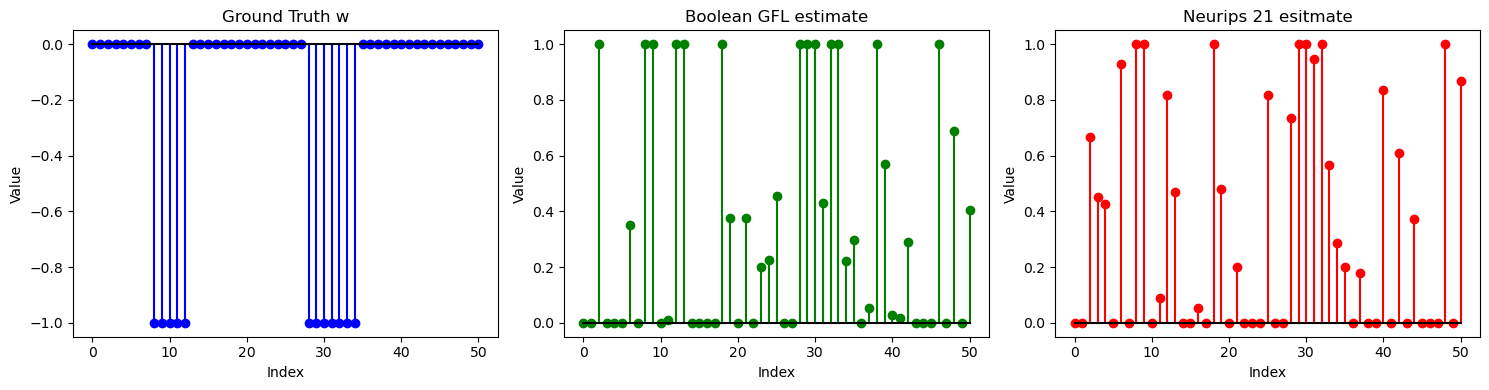

In [32]:
# Create a figure with three subplots in a row
fig, axes = plt.subplots(1, 3, figsize=(15, 4))  # 1 row, 3 columns

# Plot the first stem plot
axes[0].stem(w, linefmt='b-', markerfmt='bo', basefmt='k')
axes[0].set_title("Ground Truth w")
axes[0].set_xlabel("Index")
axes[0].set_ylabel("Value")

# Plot the second stem plot
axes[1].stem(uout_ppi, linefmt='g-', markerfmt='go', basefmt='k')
axes[1].set_title("Boolean GFL estimate")
axes[1].set_xlabel("Index")
axes[1].set_ylabel("Value")

# Plot the third stem plot
axes[2].stem(uout, linefmt='r-', markerfmt='ro', basefmt='k')
axes[2].set_title("Neurips 21 esitmate")
axes[2].set_xlabel("Index")
axes[2].set_ylabel("Value")

# Adjust layout to prevent overlap
plt.tight_layout()

# Show the plots
plt.show()

NameError: name 'uout_ppi' is not defined

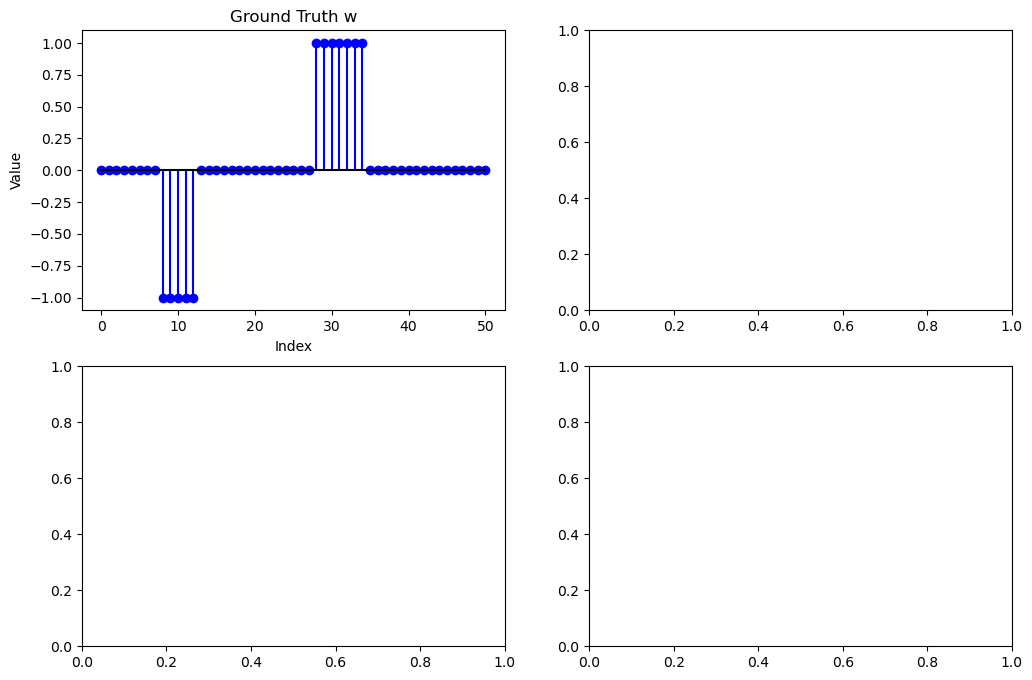

In [19]:
# Create a 2x2 grid of subplots
fig, axes = plt.subplots(2, 2, figsize=(12, 8))  # 2 rows, 2 columns

# Plot the first stem plot (top-left)
axes[0, 0].stem(w, linefmt='b-', markerfmt='bo', basefmt='k')
axes[0, 0].set_title("Ground Truth w")
axes[0, 0].set_xlabel("Index")
axes[0, 0].set_ylabel("Value")

# Plot the second stem plot (top-right)
axes[0, 1].stem(uout_ppi, linefmt='g-', markerfmt='go', basefmt='k')
axes[0, 1].set_title("Boolean GFL Estimate")
axes[0, 1].set_xlabel("Index")
axes[0, 1].set_ylabel("Value")

# Plot the third stem plot (bottom-left)
axes[1, 0].stem(uout, linefmt='r-', markerfmt='ro', basefmt='k')
axes[1, 0].set_title("Neurips 21 Estimate")
axes[1, 0].set_xlabel("Index")
axes[1, 0].set_ylabel("Value")

# Plot the fourth stem plot (bottom-right)
axes[1, 1].stem(beta, linefmt='m-', markerfmt='mo', basefmt='k')
axes[1, 1].set_title("Fast GFL Estimate")
axes[1, 1].set_xlabel("Index")
axes[1, 1].set_ylabel("Value")

# Adjust layout to prevent overlap
plt.tight_layout()

# Show the plots
plt.show()

<StemContainer object of 3 artists>

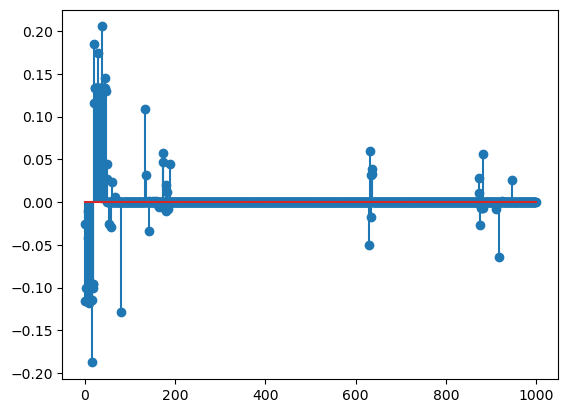

In [ ]:
from scipy.io import loadmat
data = loadmat('./code_fgfl_aaai14/result.mat')
beta = data['beta']
plt.stem(beta)

In [24]:
from scipy.io import loadmat

# Load the .mat file
data = loadmat('beta.mat')
beta = data['beta'].flatten()  # Flatten if needed for plotting

# Load the .mat file
data = loadmat('beta_corr.mat')
beta_corr = data['beta'].flatten()  # Flatten if needed for plotting


## 1.2.2 Highly correlated features

In [17]:
Num_Nodes = [8, 5, 6, 9, 7, 10, 6]
AdjMat, BlkMat = generate_random_graph(Num_Nodes, 0.03)

Selected_Module = [1, 4]
n = 30
b = 4
snr = 10

y, X, w, Group, Cov = SynData_GFL_v2(Num_Nodes, Selected_Module, n, b, snr)

340.0
[8, 9, 10, 11, 12, 28, 29, 30, 31, 32, 33, 34]
[0, 1, 2, 3, 4, 5, 6, 7, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50]


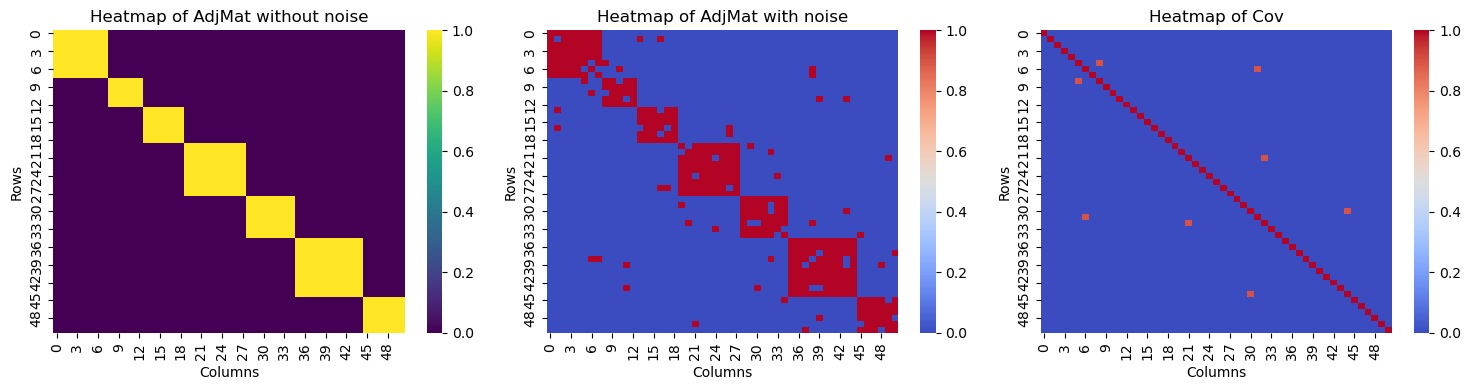

In [ ]:
# Create a figure with two subplots
fig, axes = plt.subplots(1, 3, figsize=(15, 4))  # 1 row, 2 columns

# Plot heatmap for the first matrix
sns.heatmap(BlkMat, cmap="viridis", ax=axes[0])
axes[0].set_title("Heatmap of AdjMat without noise")
axes[0].set_xlabel("Columns")
axes[0].set_ylabel("Rows")

# Plot heatmap for the second matrix
sns.heatmap(AdjMat,  cmap="coolwarm", ax=axes[1])
axes[1].set_title("Heatmap of AdjMat with noise")
axes[1].set_xlabel("Columns")
axes[1].set_ylabel("Rows")

# Plot heatmap for the second matrix
sns.heatmap(Cov,  cmap="coolwarm", ax=axes[2])
axes[2].set_title("Heatmap of Cov")
axes[2].set_xlabel("Columns")
axes[2].set_ylabel("Rows")

# Adjust layout and show the plot
plt.tight_layout()
plt.show()

In [18]:
import scipy.io as sio
import numpy as np

# Save Python data to MATLAB .mat file
sio.savemat('gfl_data_corr.mat', {
    'X': X,
    'y': y,
    'AdjMat': AdjMat,
    'pho': pho,
    'lamb': lamb
})


In [43]:
# method GFL
p = np.sum(Num_Nodes)
uSimplex = np.ones((p, 1)) * (1 / p)
k = 18
pho = 10
lamb = 0.2
# Compute the degree matrix
degree_matrix = np.diag(np.sum(AdjMat, axis=1))
# Compute the Laplacian matrix
L = degree_matrix - AdjMat

options = {'maxIter': 500, 'verbose': 0}

funObj_PPI = lambda w: L0GL_PPI_Obj(w, X, y, L, pho, lamb)
funProj_PPI = lambda w: ProjCSimplex_Gurobi_LB(w, k)
        
uout_ppi, obj, _ = minConF_PQN(funObj_PPI, uSimplex, funProj_PPI, options)
uout_ppi = ProjCSimplex_Gurobi_LB(uout_ppi, k)

In [20]:
# method without graph info
funObj_PPI = lambda w: L0GLObj(w, X, y, pho)
funProj_PPI = lambda w: ProjCSimplex_Gurobi_LB(w, k)
        
uout_, obj, _ = minConF_PQN(funObj_PPI, uSimplex, funProj_PPI, options)
uout = ProjCSimplex_Gurobi_LB(uout_, k)

Iteration 3: Step size t = 0.16492843170070492, f_new = [[0.00609442]], f_old = [[-0.00504103]]
Iteration 9: Step size t = 0.08430322939375245, f_new = [[0.00323487]], f_old = [[-0.00085808]]
Iteration 10: Step size t = 0.10436407893872424, f_new = [[0.00015658]], f_old = [[-0.00041991]]
Iteration 5: Step size t = 0.23926437990608862, f_new = [[1.05300096e-05]], f_old = [[-2.18878958e-05]]
Iteration 5: Step size t = 0.4452212929352556, f_new = [[1.02201795e-06]], f_old = [[-2.00428079e-06]]


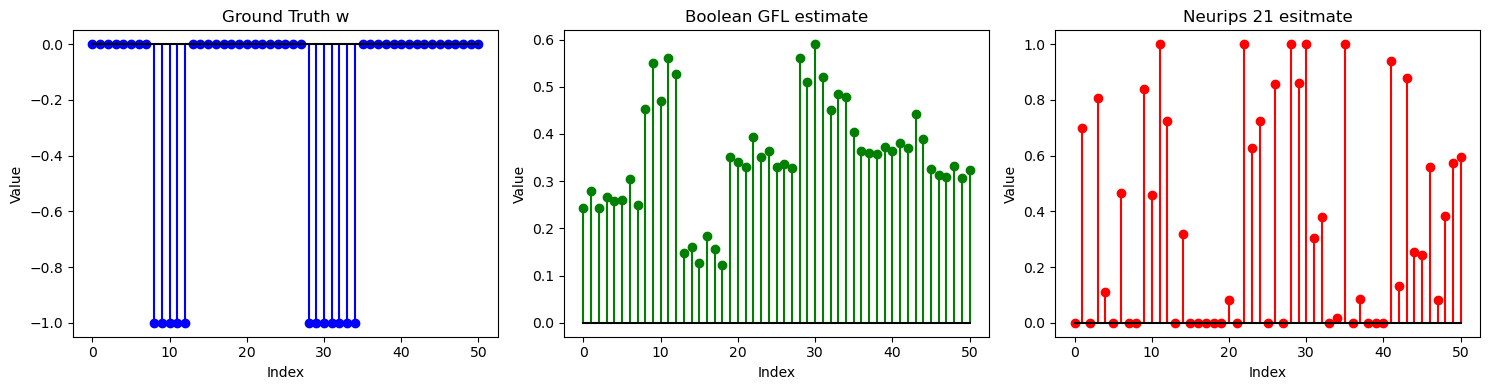

In [27]:
# Create a figure with three subplots in a row
fig, axes = plt.subplots(1, 3, figsize=(15, 4))  # 1 row, 3 columns

# Plot the first stem plot
axes[0].stem(w, linefmt='b-', markerfmt='bo', basefmt='k')
axes[0].set_title("Ground Truth w")
axes[0].set_xlabel("Index")
axes[0].set_ylabel("Value")

# Plot the second stem plot
axes[1].stem(uout_ppi, linefmt='g-', markerfmt='go', basefmt='k')
axes[1].set_title("Boolean GFL estimate")
axes[1].set_xlabel("Index")
axes[1].set_ylabel("Value")

# Plot the third stem plot
axes[2].stem(uout, linefmt='r-', markerfmt='ro', basefmt='k')
axes[2].set_title("Neurips 21 esitmate")
axes[2].set_xlabel("Index")
axes[2].set_ylabel("Value")

# Adjust layout to prevent overlap
plt.tight_layout()

# Show the plots
plt.show()

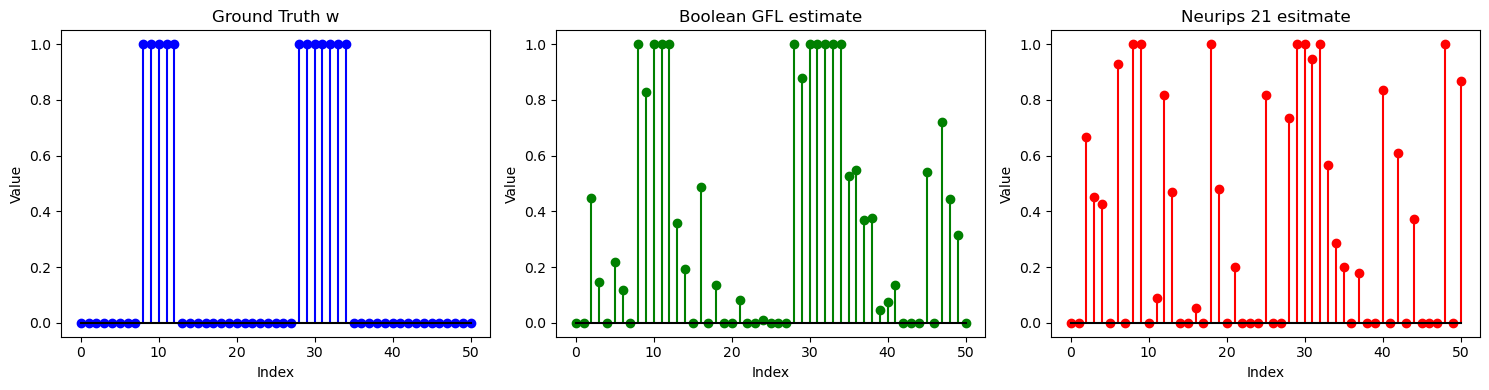

In [44]:
# Create a figure with three subplots in a row
fig, axes = plt.subplots(1, 3, figsize=(15, 4))  # 1 row, 3 columns

# Plot the first stem plot
axes[0].stem(w, linefmt='b-', markerfmt='bo', basefmt='k')
axes[0].set_title("Ground Truth w")
axes[0].set_xlabel("Index")
axes[0].set_ylabel("Value")

# Plot the second stem plot
axes[1].stem(uout_ppi, linefmt='g-', markerfmt='go', basefmt='k')
axes[1].set_title("Boolean GFL estimate")
axes[1].set_xlabel("Index")
axes[1].set_ylabel("Value")

# Plot the third stem plot
axes[2].stem(uout, linefmt='r-', markerfmt='ro', basefmt='k')
axes[2].set_title("Neurips 21 esitmate")
axes[2].set_xlabel("Index")
axes[2].set_ylabel("Value")

# Adjust layout to prevent overlap
plt.tight_layout()

# Show the plots
plt.show()

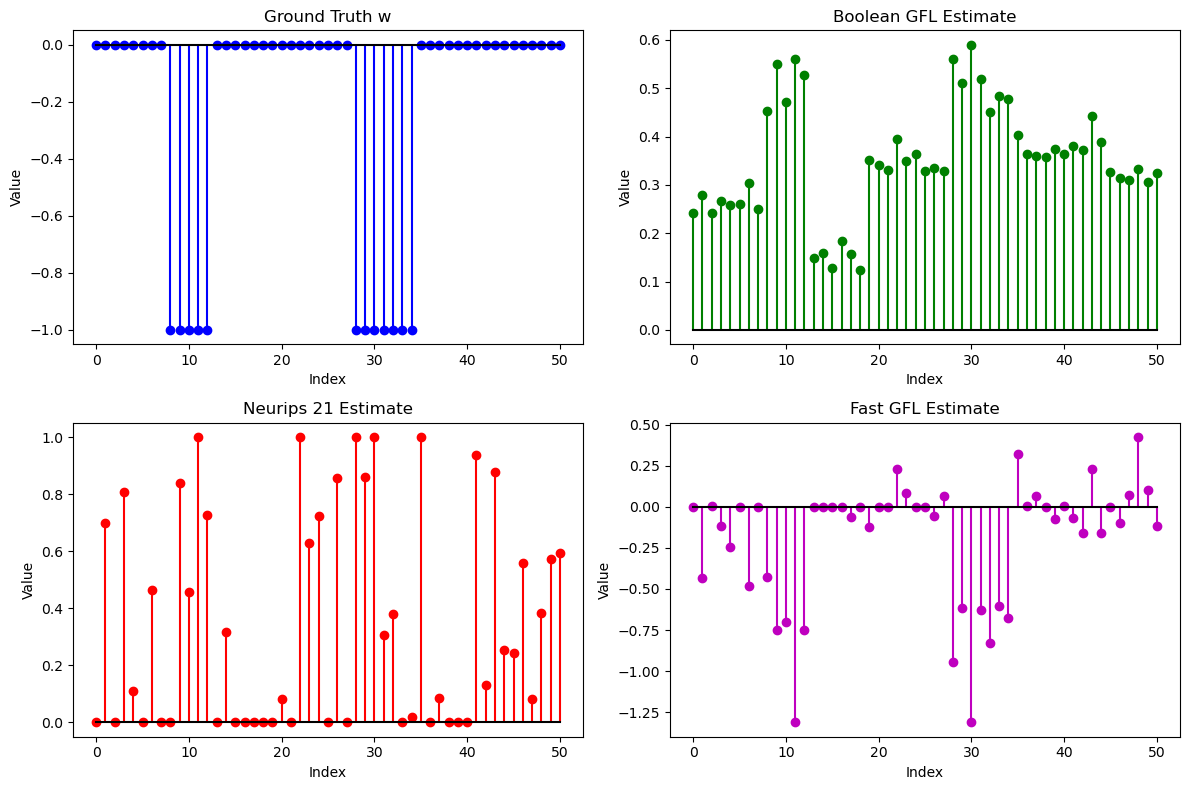

In [ ]:
# Create a 2x2 grid of subplots
fig, axes = plt.subplots(2, 2, figsize=(12, 8))  # 2 rows, 2 columns

# Plot the first stem plot (top-left)
axes[0, 0].stem(w, linefmt='b-', markerfmt='bo', basefmt='k')
axes[0, 0].set_title("Ground Truth w")
axes[0, 0].set_xlabel("Index")
axes[0, 0].set_ylabel("Value")

# Plot the second stem plot (top-right)
axes[0, 1].stem(uout_ppi, linefmt='g-', markerfmt='go', basefmt='k')
axes[0, 1].set_title("Boolean GFL Estimate")
axes[0, 1].set_xlabel("Index")
axes[0, 1].set_ylabel("Value")

# Plot the third stem plot (bottom-left)
axes[1, 0].stem(uout, linefmt='r-', markerfmt='ro', basefmt='k')
axes[1, 0].set_title("Neurips 21 Estimate")
axes[1, 0].set_xlabel("Index")
axes[1, 0].set_ylabel("Value")

# Plot the fourth stem plot (bottom-right)
axes[1, 1].stem(beta_corr, linefmt='m-', markerfmt='mo', basefmt='k')
axes[1, 1].set_title("Fast GFL Estimate")
axes[1, 1].set_xlabel("Index")
axes[1, 1].set_ylabel("Value")

# Adjust layout to prevent overlap
plt.tight_layout()

# Show the plots
plt.show()
